### Bayesian Neural Network (Julia)

## Import Packages

In [ ]:
using Pkg
using ADCME
using PyPlot 
using ProgressMeter
using Statistics
using Dates

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [ ]:
start = now()

2022-08-16T07:50:33.780

### Data

[1.0095929892611664; 4.263787669716048; 3.9908417708002757; 4.930856277674437; 3.9642634731867235; 6.32327012707073; 6.384180141915694; 4.2403200934848995; 1.7918469885129829; -2.426277054368263; -1.2638855570772267; -1.3398520061762087; -2.2877862059338088; 0.2526718813223886; 0.8580088982662665; 5.7598020563159436; 5.098996397322182; 8.951694826905182; 9.814070588045883; 12.04925749328134; 13.740552054081006; 12.852341068140717; 13.429071225226723; 12.559475309516785; 15.503158630504945; 14.845957083386937; 15.707510355099215; 16.579807435769673; 21.46543655933984; 25.507678227848185; 31.79739323705705; 39.7938868497634;;]

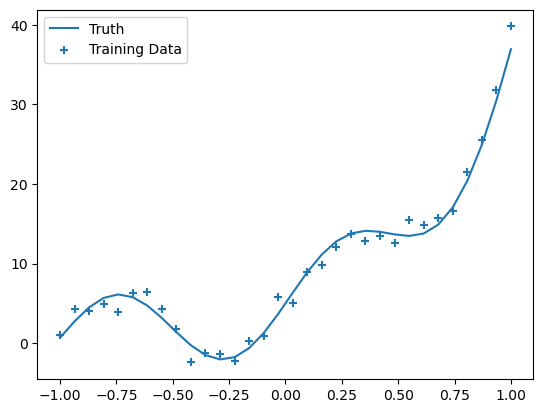

PyObject <matplotlib.legend.Legend object at 0x7f13e18b6f10>

In [ ]:
function f(x, σ)
    ε = randn(size(x)...) * σ
    #println(x)
    return 5 * (sin.(2π*x) + exp.(2*x))+ ε
end

batch_size = 32
noise = 1.0

X = reshape(LinRange(-1, 1, batch_size)|>Array, :, 1)
y = [1.0095929892611664; 4.263787669716048; 3.9908417708002757; 4.930856277674437; 3.9642634731867235; 6.32327012707073; 6.384180141915694; 4.2403200934848995; 1.7918469885129829; -2.426277054368263; -1.2638855570772267; -1.3398520061762087; -2.2877862059338088; 0.2526718813223886; 0.8580088982662665; 5.7598020563159436; 5.098996397322182; 8.951694826905182; 9.814070588045883; 12.04925749328134; 13.740552054081006; 12.852341068140717; 13.429071225226723; 12.559475309516785; 15.503158630504945; 14.845957083386937; 15.707510355099215; 16.579807435769673; 21.46543655933984; 25.507678227848185; 31.79739323705705; 39.7938868497634;;]
#y = f(X, noise)
print(y)
y_true = f(X, 0.0)

close("all")
scatter(X, y, marker="+", label="Training Data")
#scatter(X, y_temp, marker="*", label="Training Data 2")

plot(X, y_true, label="Truth")
legend()

### Bayesian NN Model

In [ ]:
mutable struct VariationalLayer
    units
    activation
    prior_σ1
    prior_σ2
    prior_π1
    prior_π2
    Wμ
    bμ
    Wρ
    bρ
    init_σ
end

function VariationalLayer(units; activation=relu, prior_σ1=1.5, prior_σ2=0.1,
        prior_π1=0.5)
    init_σ = sqrt(
        prior_π1 * prior_σ1^2 + (1-prior_π1)*prior_σ2^2
    )
    VariationalLayer(units, activation, prior_σ1, prior_σ2, prior_π1, 1-prior_π1,
                        missing, missing, missing, missing, init_σ)
end

function kl_loss(vl, w, μ, σ)
    dist = ADCME.Normal(μ,σ)
    return sum(logpdf(dist, w)-logprior(vl, w))
end

function logprior(vl, w)
    dist1 = ADCME.Normal(constant(0.0), vl.prior_σ1)
    dist2 = ADCME.Normal(constant(0.0), vl.prior_σ2)
    log(vl.prior_π1*exp(logpdf(dist1, w)) + vl.prior_π2*exp(logpdf(dist2, w)))
end

function (vl::VariationalLayer)(x)
    x = constant(x)
    if ismissing(vl.bμ)
        vl.Wμ = get_variable(vl.init_σ*randn(size(x,2), vl.units))
        vl.Wρ = get_variable(zeros(size(x,2), vl.units))
        vl.bμ = get_variable(vl.init_σ*randn(1, vl.units))
        vl.bρ = get_variable(zeros(1, vl.units))
    end
    Wσ = softplus(vl.Wρ)
    W = vl.Wμ + Wσ.*normal(size(vl.Wμ)...) 
    bσ = softplus(vl.bρ)
    b = vl.bμ + bσ.*normal(size(vl.bμ)...)
    loss = kl_loss(vl, W, vl.Wμ, Wσ) + kl_loss(vl, b, vl.bμ, bσ)
    out = vl.activation(x * W + b)
    return out, loss 
end

function neg_log_likelihood(y_obs, y_pred, σ)
    y_obs = constant(y_obs)
    dist = ADCME.Normal(y_pred, σ)
    sum(-logpdf(dist, y_obs))
end

ipt = placeholder(X)
x, loss1 = VariationalLayer(20, activation=relu)(ipt)
x, loss2 = VariationalLayer(20, activation=relu)(x)
x, loss3 = VariationalLayer(1, activation=x->x)(x)

loss_lf = neg_log_likelihood(y, x, noise)
loss = loss1 + loss2 + loss3 + loss_lf

PyObject <tf.Tensor 'add_20:0' shape=() dtype=float64>

### Prediction

2022-08-16 07:50:54.755353: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 07:50:54.761228: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2022-08-16 07:50:54.761926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x12ed08c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-16 07:50:54.761963: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0,1
OMP: Info #156: KMP_AFFINITY: 2 

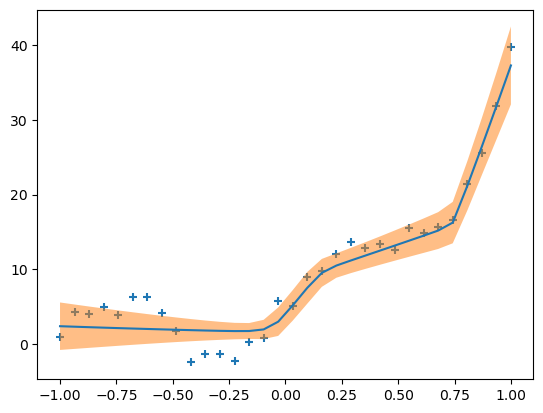

PyObject <matplotlib.collections.PolyCollection object at 0x7f13e1879790>

In [ ]:
opt = AdamOptimizer(0.08).minimize(loss)
sess = Session(); init(sess)
@showprogress for i = 1:1500
    run(sess, opt)
end

X_test = reshape(LinRange(-1,1,32)|>Array, :, 1)
y_pred_list = []

@showprogress for i = 1:1000
    y_pred = run(sess, x, ipt=>X_test)
    push!(y_pred_list, y_pred)
end

y_preds = hcat(y_pred_list...)

y_mean = mean(y_preds, dims=2)[:]
y_std = std(y_preds, dims=2)[:]

close("all")
plot(X_test, y_mean)
scatter(X[:], y[:], marker="+")
fill_between(X_test[:], y_mean-2y_std, y_mean+2y_std, alpha=0.5)

## Error

In [ ]:
function mse(y, y_pred)

  error = 0
  for i in 1:length(y)

    error = error + (y[i] - y_pred[i])^2
    #println(error)
  end

  return error
  end


mse (generic function with 1 method)

In [ ]:
mse(y, y_mean)

149.86053018329852

In [ ]:
end2 = now()
time_taken = (end2 - start) 
println("Total  Time taken: ", Dates.value(time_taken)/1000, " seconds")

Total  Time taken: 29.9 seconds
